In [42]:
from dolfin import *
import numpy as np

In [43]:
import dolfin
dolfin.__version__

'2018.2.0.dev0'

In [44]:
# Create classes for defining parts of the boundaries and the interior
# of the domain
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return x[:,0]== 0.0

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return x[:,0]== 1.0

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return x[:,1]== 0.0

class Top(SubDomain):
    def inside(self, x, on_boundary):
        return x[:,1]==1.0
    
class Obstacle(SubDomain):
    def inside(self, x, on_boundary):
        return np.logical_and(np.logical_and(x[:, 0] < 1.0 - np.finfo(float).eps,
                              x[:, 0] > 0.2 - np.finfo(float).eps),
                              np.logical_and(x[:, 1] < 0.7 - np.finfo(float).eps,
                              x[:, 1] > 0.5 - np.finfo(float).eps))

In [45]:
# Initialize sub-domain instances
left = Left()
top = Top()
right = Right()
bottom = Bottom()
obstacle = Obstacle()

In [46]:
# Define mesh
mesh = UnitSquareMesh(dolfin.MPI.comm_world,64, 64)

In [47]:
# Initialize mesh function for interior domains
domains = MeshFunction("size_t", mesh, mesh.topology.dim,0)

In [48]:
obstacle.mark(domains, 1)

In [50]:
# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology.dim-1,0)
left.mark(boundaries, 1)
top.mark(boundaries, 2)
right.mark(boundaries, 3)
bottom.mark(boundaries, 4)

In [51]:
# Define input data
from ufl import SpatialCoordinate, inner, grad, lhs, rhs, dot, exp, Measure
from dolfin.fem import assemble_scalar

In [52]:
a0 = 1.0
a1 = 0.01
x = SpatialCoordinate(mesh)
g_L = exp(- 10*(- pow(x[1] - 0.5, 2)))
g_R = 1.0
f = 1.0

In [53]:
# Define function space and basis functions
V = FunctionSpace(mesh, ("CG", 2))
u = TrialFunction(V)
v = TestFunction(V)

In [54]:
u5 = Function(V)
u5.vector().set(5.0)

u0 = Function(V)
u0.vector().set(0.0)

In [55]:
# Define Dirichlet boundary conditions at top and bottom boundaries
bcs = [DirichletBC(V, u5, top),
       DirichletBC(V, u0, bottom)]

In [56]:
# Define new measures associated with the interior domains and
# exterior boundaries
dx = Measure('dx', domain=mesh, subdomain_data=domains)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

In [57]:
# Define variational form
F = (inner(a0*grad(u), grad(v))*dx(0) + inner(a1*grad(u), grad(v))*dx(1)
     - g_L*v*ds(1) - g_R*v*ds(3)
     - f*v*dx(0) - f*v*dx(1))

In [58]:
# Separate left and right hand sides of equation
a, L = lhs(F), rhs(F)

In [59]:
# Solve problem
u = Function(V)
solve(a == L, u, bcs)

In [60]:
# Evaluate integral of normal gradient over top boundary
n = FacetNormal(mesh)
m1 = dot(grad(u), n)*ds(2)
v1 = assemble_scalar(m1)
print("\int grad(u) * n ds(2) = ", v1)

\int grad(u) * n ds(2) =  -0.37481009678796084


In [65]:
# Evaluate integral of u over the obstacle
m2 = u*dx(1)
v2 = assemble_scalar(m2)
print("\int u dx(1) = ", v2)

\int u dx(1) =  0.49063047221422823


In [66]:
# Plot solution
import matplotlib.pyplot as plt
%matplotlib inline
from dolfin.plotting import plot

In [89]:
u(1)

TypeError: __call__() missing 1 required positional argument: 'bb_tree'

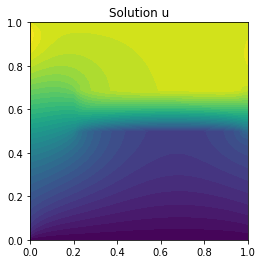

In [35]:
plt.figure()
plot(u, title="Solution u")

In [36]:
# Plot solution and gradient
#plt.figure()
#plot(grad(u), title="Projected grad(u)")